In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error, roc_auc_score

In [2]:
# Download latest version
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

print("Path to dataset files:", path)

100%|██████████| 6.28M/6.28M [00:00<00:00, 134MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24


In [3]:
# List all files available in the dataset
for file in os.listdir(path):
    print(file)


pit_stops.csv
status.csv
lap_times.csv
sprint_results.csv
driver_standings.csv
constructors.csv
results.csv
circuits.csv
seasons.csv
qualifying.csv
constructor_standings.csv
races.csv
drivers.csv
constructor_results.csv


In [4]:
# To quickly inspect each table
def show_info(df, name):
    print(f"\n{name}: shape={df.shape}")
    print("Columns:", list(df.columns))
    print(df.head(3))

# Load core CSVs
races         = pd.read_csv(os.path.join(path, "races.csv"))
results       = pd.read_csv(os.path.join(path, "results.csv"))
drivers       = pd.read_csv(os.path.join(path, "drivers.csv"))
constructors  = pd.read_csv(os.path.join(path, "constructors.csv"))
qualifying    = pd.read_csv(os.path.join(path, "qualifying.csv"))

# Quick audit
show_info(races, "races")
show_info(results, "results")
show_info(drivers, "drivers")
show_info(constructors, "constructors")
show_info(qualifying, "qualifying")



races: shape=(1125, 18)
Columns: ['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time']
   raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       2  2009      2          2   Malaysian Grand Prix  2009-04-05   
2       3  2009      3         17     Chinese Grand Prix  2009-04-19   

       time                                                url fp1_date  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
1  09:00:00  http://en.wikipedia.org/wiki/2009_Malaysian_Gr...       \N   
2  07:00:00  http://en.wikipedia.org/wiki/2009_Chinese_Gran...       \N   

  fp1_time fp2_date fp2_time fp3_date fp3_time quali_date quali_time  \
0       \N       \N       \N       \N       \N         \N         \N   
1       \N       \N       \N  

In [5]:
# Step 3 — Merge datasets to form modeling table

# Select needed columns
races_sel = races[['raceId', 'year', 'name']]
drivers_sel = drivers[['driverId', 'forename', 'surname', 'nationality']]
constructors_sel = constructors[['constructorId', 'name']].rename(columns={'name': 'constructor_name'})
results_sel = results[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder', 'points', 'laps', 'milliseconds', 'fastestLapSpeed']]
qualifying_sel = qualifying[['raceId', 'driverId', 'position']].rename(columns={'position': 'qualifying_position'})

# Merge step-by-step
df = results_sel.merge(races_sel, on='raceId', how='left')
df = df.merge(drivers_sel, on='driverId', how='left')
df = df.merge(constructors_sel, on='constructorId', how='left')
df = df.merge(qualifying_sel, on=['raceId', 'driverId'], how='left')

# Drop rows with missing outcome
df = df.dropna(subset=['positionOrder'])

print("Final dataset shape:", df.shape)
df.head()


Final dataset shape: (26759, 16)


,raceId,driverId,constructorId,grid,positionOrder,points,laps,milliseconds,fastestLapSpeed,year,name,forename,surname,nationality,constructor_name,qualifying_position
0,18,1,1,1,1,10.0,58,5690616,218.300,2008,Australian Grand Prix,Lewis,Hamilton,British,McLaren,1.0
1,18,2,2,5,2,8.0,58,5696094,217.586,2008,Australian Grand Prix,Nick,Heidfeld,German,BMW Sauber,5.0
2,18,3,3,7,3,6.0,58,5698779,216.719,2008,Australian Grand Prix,Nico,Rosberg,German,Williams,7.0
3,18,4,4,11,4,5.0,58,5707797,215.464,2008,Australian Grand Prix,Fernando,Alonso,Spanish,Renault,12.0
4,18,5,1,3,5,4.0,58,5708630,218.385,2008,Australian Grand Prix,Heikki,Kovalainen,Finnish,McLaren,3.0


In [6]:
# Step 4 — Feature setup

# Define target: 1 if top 3 finish, else 0
df['podium'] = df['positionOrder'].apply(lambda x: 1 if x <= 3 else 0)

# Select features
features = ['grid', 'qualifying_position', 'fastestLapSpeed', 'laps', 'milliseconds']
target = 'podium'

# Drop missing values for selected features
model_df = df[features + [target]].dropna()

print("Modeling dataset shape:", model_df.shape)
model_df.head()

Modeling dataset shape: (10494, 6)


,grid,qualifying_position,fastestLapSpeed,laps,milliseconds,podium
0,1,1.0,218.300,58,5690616,1
1,5,5.0,217.586,58,5696094,1
2,7,7.0,216.719,58,5698779,1
3,11,12.0,215.464,58,5707797,0
4,3,3.0,218.385,58,5708630,0


In [7]:
# Step 5A — Clean numeric columns

# Convert all numeric features to float, forcing non-numeric values to NaN
for col in ['grid', 'qualifying_position', 'fastestLapSpeed', 'laps', 'milliseconds']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Recreate modeling dataframe after cleaning
features = ['grid', 'qualifying_position', 'fastestLapSpeed', 'laps', 'milliseconds']
target = 'podium'

model_df = df[features + [target]].dropna()

print("After cleaning:", model_df.shape)
model_df.head()


After cleaning: (4263, 6)


,grid,qualifying_position,fastestLapSpeed,laps,milliseconds,podium
0,1,1.0,218.300,58,5690616.0,1
1,5,5.0,217.586,58,5696094.0,1
2,7,7.0,216.719,58,5698779.0,1
3,11,12.0,215.464,58,5707797.0,0
4,3,3.0,218.385,58,5708630.0,0


In [8]:
# Step 5 — Baseline Logistic Regression Model

# Split data
X = model_df[features]
y = model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8183

Confusion Matrix:
 [[541  66]
 [ 89 157]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87       607
           1       0.70      0.64      0.67       246

    accuracy                           0.82       853
   macro avg       0.78      0.76      0.77       853
weighted avg       0.81      0.82      0.82       853



               Feature  Coefficient
1  qualifying_position    -1.700727
0                 grid    -0.684430
2      fastestLapSpeed     0.064002
3                 laps     0.061380
4         milliseconds     0.028274


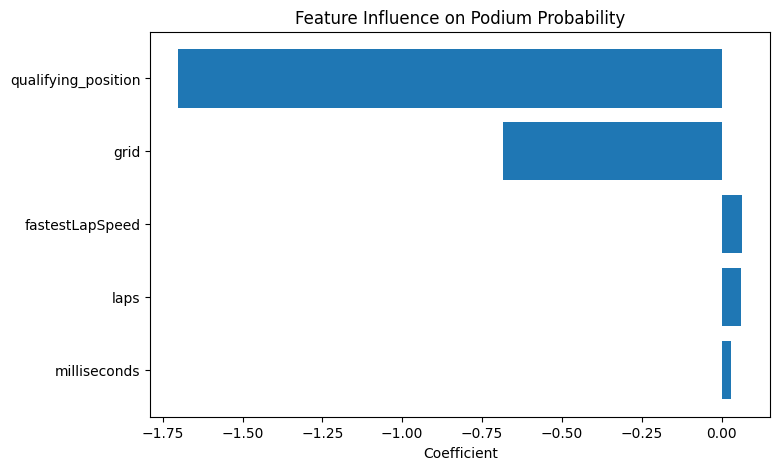

In [9]:
# Get feature importance (coefficients)
importance = model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': importance,
    'AbsValue': np.abs(importance)
}).sort_values('AbsValue', ascending=False)

# Display sorted importance
print(feature_importance[['Feature', 'Coefficient']])

# Visualize
plt.figure(figsize=(8,5))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Feature Influence on Podium Probability')
plt.gca().invert_yaxis()
plt.show()


In [10]:
# Step 7.1 — Calculate driver experience (number of races before current one)
df = df.sort_values(['driverId', 'year', 'raceId'])
df['driver_experience'] = df.groupby('driverId').cumcount()

df[['driverId','year','name','forename','surname','driver_experience']].head(10)


,driverId,year,name,forename,surname,driver_experience
370,1,2007,Australian Grand Prix,Lewis,Hamilton,0
391,1,2007,Malaysian Grand Prix,Lewis,Hamilton,1
413,1,2007,Bahrain Grand Prix,Lewis,Hamilton,2
435,1,2007,Spanish Grand Prix,Lewis,Hamilton,3
457,1,2007,Monaco Grand Prix,Lewis,Hamilton,4
478,1,2007,Canadian Grand Prix,Lewis,Hamilton,5
500,1,2007,United States Grand Prix,Lewis,Hamilton,6
524,1,2007,French Grand Prix,Lewis,Hamilton,7
546,1,2007,British Grand Prix,Lewis,Hamilton,8
574,1,2007,European Grand Prix,Lewis,Hamilton,9


In [11]:
# Step 7.2 — Calculate constructor average points per year (seasonal strength)
constructor_strength = (
    df.groupby(['constructorId','year'])['points']
      .mean()
      .reset_index()
      .rename(columns={'points':'constructor_strength'})
)

# Merge back into main dataframe
df = df.merge(constructor_strength, on=['constructorId','year'], how='left')

df[['constructor_name','year','constructor_strength']].head(10)


,constructor_name,year,constructor_strength
0,McLaren,2007,6.411765
1,McLaren,2007,6.411765
2,McLaren,2007,6.411765
3,McLaren,2007,6.411765
4,McLaren,2007,6.411765
5,McLaren,2007,6.411765
6,McLaren,2007,6.411765
7,McLaren,2007,6.411765
8,McLaren,2007,6.411765
9,McLaren,2007,6.411765


In [12]:
# Updated feature list
features = ['grid','qualifying_position','fastestLapSpeed','laps',
            'driver_experience','constructor_strength']

target = 'podium'

# Drop missing rows for now
model_df2 = df[features + [target]].dropna()
print("New modeling dataset shape:", model_df2.shape)
model_df2.head()

New modeling dataset shape: (8231, 7)


,grid,qualifying_position,fastestLapSpeed,laps,driver_experience,constructor_strength,podium
0,4,4.0,221.083,58,0,6.411765,1
1,4,4.0,206.355,56,1,6.411765,1
2,2,2.0,206.674,57,2,6.411765,1
3,4,4.0,202.205,65,3,6.411765,1
4,2,2.0,159.528,78,4,6.411765,1


In [13]:
# Step 8 — Retrain Logistic Regression with engineered features

X = model_df2[features]
y = model_df2[target]

# Split (still 80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model2 = LogisticRegression(max_iter=1000)
model2.fit(X_train_scaled, y_train)

# Evaluate
y_pred2 = model2.predict(X_test_scaled)

print("New Accuracy:", round(accuracy_score(y_test, y_pred2), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred2))


New Accuracy: 0.9029

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      1401
           1       0.71      0.59      0.64       246

    accuracy                           0.90      1647
   macro avg       0.82      0.77      0.79      1647
weighted avg       0.90      0.90      0.90      1647



                Feature  Coefficient
1   qualifying_position    -1.487339
0                  grid    -0.763553
5  constructor_strength     0.681946
3                  laps     0.672734
2       fastestLapSpeed     0.247384
4     driver_experience    -0.006542


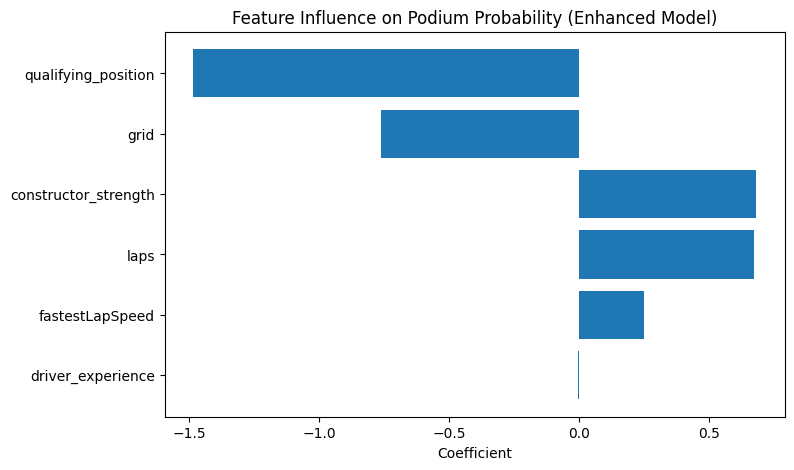

In [14]:
importance = model2.coef_[0]
feature_importance2 = pd.DataFrame({
    'Feature': features,
    'Coefficient': importance,
    'AbsValue': np.abs(importance)
}).sort_values('AbsValue', ascending=False)

print(feature_importance2[['Feature','Coefficient']])

plt.figure(figsize=(8,5))
plt.barh(feature_importance2['Feature'], feature_importance2['Coefficient'])
plt.xlabel('Coefficient')
plt.title('Feature Influence on Podium Probability (Enhanced Model)')
plt.gca().invert_yaxis()
plt.show()


In [15]:
# Step 10.1 — Random Forest model

# Train/test split (same data as before)
X = model_df2[features]
y = model_df2[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_model = RandomForestClassifier(
    n_estimators=200, max_depth=None, random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8968

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1401
           1       0.68      0.57      0.62       246

    accuracy                           0.90      1647
   macro avg       0.81      0.76      0.78      1647
weighted avg       0.89      0.90      0.89      1647



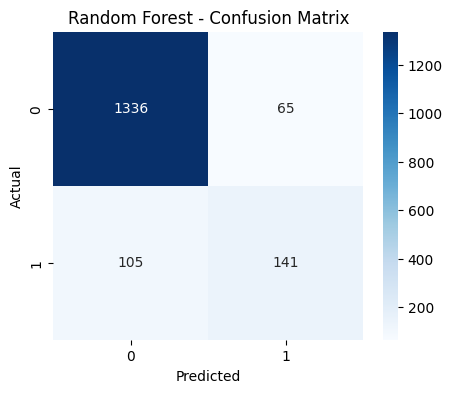

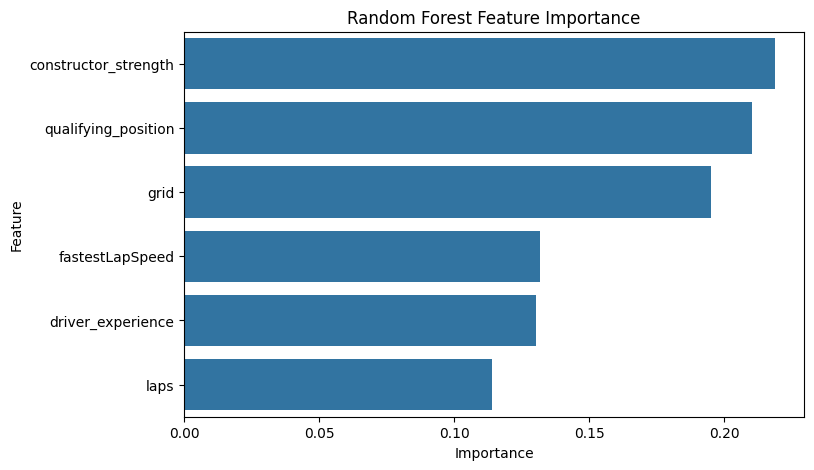

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df)
plt.title("Random Forest Feature Importance")
plt.show()


In [17]:
# Predict probabilities for both models
y_pred_proba_lr = model2.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate Mean Squared Prediction Error (MSPE)
mspe_lr = mean_squared_error(y_test, y_pred_proba_lr)
mspe_rf = mean_squared_error(y_test, y_pred_proba_rf)

# Calculate ROC–AUC
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Logistic Regression → MSPE: {mspe_lr:.4f} | AUC: {auc_lr:.4f}")
print(f"Random Forest       → MSPE: {mspe_rf:.4f} | AUC: {auc_rf:.4f}")


Logistic Regression → MSPE: 0.0706 | AUC: 0.9223
Random Forest       → MSPE: 0.0734 | AUC: 0.9133


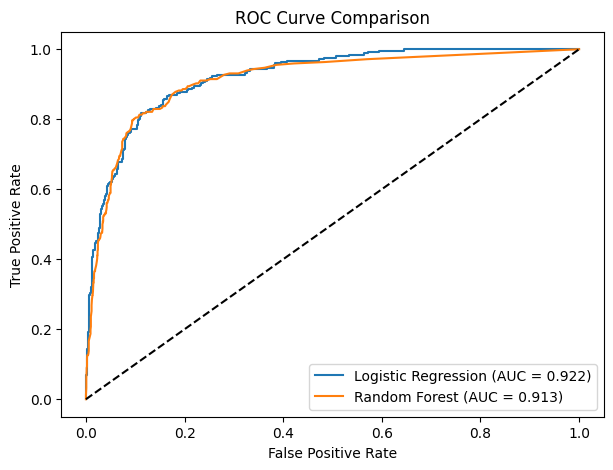

In [18]:
# ROC points
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [19]:

cv_scores = cross_val_score(model2, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Logistic Regression Cross-Validation Accuracy (mean):", round(np.mean(cv_scores), 4))
print("Standard Deviation across folds:", round(np.std(cv_scores), 4))


Logistic Regression Cross-Validation Accuracy (mean): 0.9048
Standard Deviation across folds: 0.0042


In [20]:
# Step 14 — Expanded Tableau dataset
tableau_df = df[[
    'year', 'name', 'forename', 'surname', 'nationality',
    'constructor_name', 'grid', 'qualifying_position',
    'positionOrder', 'podium', 'points', 'laps',
    'fastestLapSpeed', 'driver_experience', 'constructor_strength'
]].copy()

# Optional enrichment if 'races.csv' or 'drivers.csv' have extra info
# For example, if 'races.csv' has 'circuitId' or 'country':
# tableau_df = tableau_df.merge(races[['raceId','circuitId']], on='raceId', how='left')

# Rename columns for Tableau clarity
tableau_df.columns = [
    'Year', 'Race_Name', 'Driver_First', 'Driver_Last', 'Nationality',
    'Constructor', 'Grid_Position', 'Qualifying_Position',
    'Finish_Position', 'Podium', 'Points', 'Laps',
    'Fastest_Lap_Speed', 'Driver_Experience', 'Constructor_Strength'
]

# Export
tableau_df.to_csv("F1_Podium_Prediction_Tableau.csv", index=False)
print("✅ Tableau dataset ready:", tableau_df.shape)


✅ Tableau dataset ready: (26759, 15)


In [21]:
from google.colab import files
files.download("F1_Podium_Prediction_Tableau.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>